## Modified Slim

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
Amax = 0.1
num_param = 4
Arange = np.linspace(-Amax, Amax, num_param)
mpol = 2
RZm_max = 0.3
Rm = np.linspace(-RZm_max, RZm_max, num_param)
Zm = np.linspace(-RZm_max, RZm_max, num_param)
# begin with perfectly circular cross-section
center = np.zeros((3 + 2 * mpol))
minor_radius = 0.5

def gen_traindata(num):
    N = num
    tau = np.linspace(0, 2 * np.pi, N)
    Rm_grid = Rm
    Zm_grid = Zm
    for i in range(mpol + 1):
        Rm_grid = np.outer(Rm_grid, Rm).reshape(2 * mpol * np.ones(i + 2, dtype=int))
        Zm_grid = np.outer(Zm_grid, Zm).reshape(2 * mpol * np.ones(i + 2, dtype=int))

    # assume that minor radius R(0, 0) = 1
    R_ellipse = np.ones((N, num_param, *Rm_grid.shape))
    R0 = np.outer(
        minor_radius * np.cos(tau),
        np.ravel(np.ones((num_param, *Rm_grid.shape)))
        ).reshape(R_ellipse.shape)
    R_ellipse = (1 + R0) * R_ellipse

    # Z(0, 0) = 0
    Z_ellipse = np.ones((N, num_param, *Rm_grid.shape))
    Z0 = np.outer(
        minor_radius * np.sin(tau),
        np.ravel(np.ones((num_param, *Rm_grid.shape)))
        ).reshape(Z_ellipse.shape)
    Z_ellipse = Z0 * Z_ellipse

    A_ellipse = np.zeros((N, num_param, *Rm_grid.shape))

    for i in range(num_param):
        for m in range(1, mpol + 1):  # sum over m
            R_ellipse[:, i, ...] += np.outer(np.cos(m * tau), Rm_grid).reshape(N, *Rm_grid.shape)
            Z_ellipse[:, i, ...] += np.outer(np.sin(m * tau), Zm_grid).reshape(N, *Rm_grid.shape)
        A_ellipse[:, i, ...] = Arange[i]

    Rm_grid = np.ones((N, num_param, *Rm_grid.shape)) * Rm_grid
    Zm_grid = np.ones((N, num_param, *Zm_grid.shape)) * Zm_grid

    # Define boundary of hyper-cross-section
    inds = np.roll(np.arange(0, len(Rm_grid.shape) + 1), -1)
    x_ellipse = np.transpose(
        np.array([R_ellipse, Z_ellipse, A_ellipse]),
        inds
    )
    start = 0
    end = num_param
    for i in range(mpol):
        Rm_grid_partial = np.ones(Rm_grid.shape)
        Zm_grid_partial = np.ones(Zm_grid.shape)
        slc = [slice(None)] * len(Rm_grid.shape)
        slc[2 + i] = slice(start, end)
        Rm_grid_partial[slc] = Rm
        Zm_grid_partial[slc] = Zm
        Rm_grid_partial = Rm_grid_partial.reshape(*Rm_grid_partial.shape, 1)
        Zm_grid_partial = Zm_grid_partial.reshape(*Zm_grid_partial.shape, 1)
        x_ellipse = np.concatenate([x_ellipse, Rm_grid_partial], axis=-1)
        x_ellipse = np.concatenate([x_ellipse, Zm_grid_partial], axis=-1)

    x_ellipse = x_ellipse.reshape(
        N * num_param ** (1 + 2 * mpol),
        3 + 2 * mpol
    )
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)


spatial_domain = dde.geometry.HyperFourierEllipse(
    Amax=Amax, RZm_max=RZm_max, num_param=num_param, 
    mpol=mpol, minor_radius=minor_radius
) 
print('Done with initializing geometry')

x, u = gen_traindata(100)
print('Done with initializing train data')

n_test = 100
x_test,u_test = gen_traindata(n_test)
print('Done with initializing test data')

x_domain = spatial_domain.random_points(n_test)
print('Done with initializing random data')

x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

print('starting BC')

bc135 = dde.PointSetBC(x,u)
print('Done with BC')

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=1000,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(4, 4, 4, 4)
(100, 4, 4, 4, 4, 4, 7) (100, 4, 4, 4, 4, 4)
Done with initializing geometry
Done with initializing train data
Done with initializing test data
Done with initializing random data
starting BC
Done with BC


/Users/alankaptanoglu/deepxde_copy/deepxde/geometry/geometry_nd.py:391: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Rm_grid_partial[slc] = Rm
/Users/alankaptanoglu/deepxde_copy/deepxde/geometry/geometry_nd.py:392: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Zm_grid_partial[slc] = Zm
/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted

(100, 4, 4, 4, 4, 4)


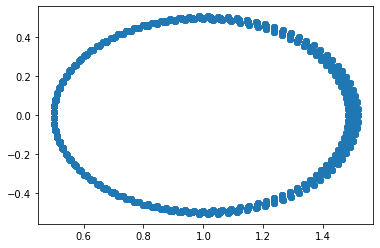

In [10]:
print(spatial_domain.R_ellipse.shape)
plt.scatter(spatial_domain.R_ellipse[:, 0, :, :, :, 0], 
            spatial_domain.Z_ellipse[:, 0, :, :, :, 0])

#### ISSUE is that Rm and Zm sums over m are incorrect... need
# to multiply m by the correct Rm and sum...

In [ ]:
# Plot collocation points for visual check
%matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='b')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

In [ ]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

In [ ]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 2
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([3 + 2 * mpol] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

In [ ]:
# Compile, train and save model
model.compile(
    "L-BFGS-B", 
    loss_weights=[1,100]
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [ ]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
#ITER = GS_parametrized(eps0, kappa0, delta0, Amax)
ITER = GS_Linear(eps=eps[0], kappa=kappa[0], delta=delta[0])
full, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
    ITER, model, Amax, num_param
)
nx = psi_true_full.shape[0]
ny = psi_true_full.shape[0]
psi_pred_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
psi_true_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
for i in range(num_param):
    for j in range(num_param):
        for k in range(num_param):
            ITER = GS_Linear(eps=eps[i], kappa=kappa[j], delta=delta[k])
            xfull, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
                ITER, model, Amax, num_param
            )
            psi_pred_parametrized[:, :, :, i, j, k] = psi_pred_full
            psi_true_parametrized[:, :, :, i, j, k] = psi_true_full


In [ ]:
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()

In [ ]:
# Plotting Setup
import matplotlib.colors as colors

for i in range(0, num_param, 2):
    plt.figure(i + 1, figsize=(20, 40))
    q = 1
    for j in range(0, num_param, 2):
        for k in range(0, num_param, 2):
            for kk in range(0, num_param, 2):
#                 zoom = ((1 + eps[j])-(1 - eps[j]))*0.05
#                 innerPoint = 1 - eps[j] - zoom
#                 outerPoint = 1 + eps[j] + zoom
#                 lowPoint   = -kappa[k] * eps[j] - zoom
#                 highPoint  = kappa[k] * eps[j] + zoom
                innerPoint = 0.5
                outerPoint = 1.5
                lowPoint = -1
                highPoint = 1
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q)
                levels = np.linspace(
                    min(psi_true_parametrized[:, :, i, j, k, kk].reshape(-1)), 0, 10
                )    
                cp = plt.contour(
                    xfull[:, :, i], yfull[:, :, i], 
                    psi_pred_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 1)
                cp = plt.contour(
                    xfull[:, :, i], 
                    yfull[:, :, i], 
                    psi_true_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 2)
                errors = abs(psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]) / np.max(
                        abs(psi_true_parametrized[:, :, i, j, k, kk]))
                cp = plt.contourf(
                    xfull[:, :, i], 
                    yfull[:, :, i], 
                    errors,
                    norm=colors.LogNorm(vmin=errors.min(), 
                                        vmax=errors.max()),
                    #levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.colorbar()
                q = q + 3

In [ ]:
import time 

nx = 30
ny = nx
zoom = 0.2
inner_point = (1 - 1.1*ITER.eps*(1+zoom))
outer_point = (1 + 1.1*ITER.eps*(1+zoom))
high_point  = (1.1*ITER.kappa * ITER.eps*(1+zoom) )
low_point   = (-1.1*ITER.kappa * ITER.eps*(1+zoom) )
x, y, A = np.meshgrid(
    np.linspace(inner_point, outer_point, nx),
    np.linspace(low_point, high_point, ny),
    np.linspace(-Amax, Amax, num_param),
    indexing='ij'
)
ones = np.ones(nx * ny * num_param)

X = np.vstack((
    np.ravel(x), np.ravel(y), np.ravel(A),
    ITER.eps * ones, ITER.kappa * ones, ITER.delta * ones
)).T
print(X.shape)
t1 = time.time()
model.predict(X)
t2 = time.time()
print(t2 - t1)

In [ ]:
Rm_grid = Rm
Zm_grid = Zm
for i in range(mpol + 1):
    print(i, Rm.shape, Rm_grid.shape)
    Rm_grid = np.outer(Rm_grid, Rm).reshape(2 * mpol * np.ones(i + 2, dtype=int))
    Zm_grid = np.outer(Zm_grid, Zm).reshape(2 * mpol * np.ones(i + 2, dtype=int))
print(np.shape(Rm_grid), mpol, np.shape(Rm))

In [ ]:
mpol * np.ones(i + 2, dtype=int)